<a href="https://colab.research.google.com/github/shivanishah/satellite-image/blob/main/satellite_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import csv
import cv2

In [2]:
!pip install Pillow
!pip install numpy
!pip install rasterio
!pip install matplotlib
!pip install scikit-learn
!pip install patchify

In [4]:
#if you have issue while installing tensorflow and segmentation models
!pip uninstall -y segmentation-models efficientnet image-classifiers keras tensorflow

In [5]:
!pip install tensorflow==2.9.1 keras==2.9.0
!pip install segmentation-models==1.0.1
!pip install efficientnet==1.0.0 image-classifiers==1.0.0

  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.9.1 which is incompatible.
  Using cached segmentation_models-1.0.1-py3-none-any.whl.metadata (938 bytes)
  Using cached image_classifiers-1.0.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)
Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
Using cached image_classifiers-1.0.0-py3-none-any.

In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.merge import merge
from PIL import Image
from patchify import patchify
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random

In [18]:
# Define the input and output folder paths
base_input_folder = "drive/MyDrive/Colab Notebooks/satellite"
categories = ["Farm", "Dense Residential", "Forest", "Sparse Residential"]
label_mapping = {
  'farm': 0,
  'dense residential': 1,
  'forest': 2,
  'sparse residential': 3
}
color_mapping = {
    0: [144/255, 238/255, 144/255],  # Light green for Farm
    1: [0/255, 0/255, 139/255],      # Dark blue for Dense Residential
    2: [0/255, 100/255, 0/255],      # Dark green for Forest
    3: [135/255, 206/255, 250/255]   # Light blue for Sparse Residential
}

In [8]:
def apply_color_mapping(mask):
  # Create an empty RGB image
  colored_mask = np.zeros((*mask.shape, 3), dtype=np.float32)
  # Apply color mapping
  for label, color in color_mapping.items():
      colored_mask[mask == label] = color
  return colored_mask

In [9]:
def convert_tiff_to_png(input_folder, output_folder):
  if not os.path.exists(output_folder):
      os.makedirs(output_folder)

  for filename in os.listdir(input_folder):
      if filename.endswith(".tiff") or filename.endswith(".tif"):
          tiff_path = os.path.join(input_folder, filename)
          png_filename = os.path.splitext(filename)[0] + ".png"
          png_path = os.path.join(output_folder, png_filename)

          with Image.open(tiff_path) as img:
              # Convert to RGB if necessary
              if img.mode != 'RGB':
                  img = img.convert('RGB')
              img.save(png_path, 'PNG')

          print(f"Converted {filename} to {png_filename}")

In [10]:
for category in categories:
    input_folder = os.path.join(base_input_folder, category)
    output_folder = os.path.join(input_folder, "pngImage")

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Call the conversion function
    convert_tiff_to_png(input_folder, output_folder)

Converted agricultural00.tif to agricultural00.png
Converted agricultural01.tif to agricultural01.png
Converted agricultural02.tif to agricultural02.png
Converted agricultural03.tif to agricultural03.png
Converted agricultural05.tif to agricultural05.png
Converted agricultural06.tif to agricultural06.png
Converted agricultural07.tif to agricultural07.png
Converted agricultural08.tif to agricultural08.png
Converted agricultural09.tif to agricultural09.png
Converted agricultural11.tif to agricultural11.png
Converted agricultural13.tif to agricultural13.png
Converted agricultural14.tif to agricultural14.png
Converted agricultural15.tif to agricultural15.png
Converted agricultural18.tif to agricultural18.png
Converted agricultural20.tif to agricultural20.png
Converted agricultural21.tif to agricultural21.png
Converted agricultural22.tif to agricultural22.png
Converted agricultural23.tif to agricultural23.png
Converted agricultural24.tif to agricultural24.png
Converted agricultural25.tif to

In [ ]:
#no need of doing this
# Define the path for the combined CSV file
combined_csv_path = os.path.join(base_input_folder, "combined_image_labels.csv")

# Function to create a single combined CSV with data from all categories
def create_combined_image_csv(base_input_folder, categories, combined_csv_path):
    with open(combined_csv_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['filename', 'class'])  # Header

        # Iterate over each category to add image data
        for category in categories:
            image_folder = os.path.join(base_input_folder, category, "pngImage")

            # Check if the folder exists before proceeding
            if not os.path.exists(image_folder):
                print(f"Warning: {image_folder} does not exist, skipping.")
                continue

            # Write data for each image in the current category folder
            for filename in os.listdir(image_folder):
                if filename.endswith(".png"):
                    csvwriter.writerow([filename, category.lower()])  # Write filename and category as class

    print(f"Combined CSV file created at {combined_csv_path}")

In [ ]:
# Call the function to create the combined CSV
create_combined_image_csv(base_input_folder, categories, combined_csv_path)

Combined CSV file created at drive/MyDrive/Colab Notebooks/satellite/combined_image_labels.csv


In [11]:
minmaxscaler = MinMaxScaler()
patch_size = 128

In [12]:
# Initialize an empty list to store labels from masks
labels_dataset = []
# Initialize an empty list to store patches from images
image_dataset = []
# Initialize an empty list to store mask from images,labels
mask_dataset = []

# Iterate over each category to process image
for category in categories:
    # Construct the path to the pngImage folder within each category
    image_folder = os.path.join(base_input_folder, category, "pngImage")

    # Check if the folder exists before proceeding
    if not os.path.exists(image_folder):
        print(f"Warning: {image_folder} does not exist, skipping.")
        continue

    # List and process all PNG images in the folder
    images = sorted(os.listdir(image_folder))
    for i, image_name in enumerate(images):
        if image_name.endswith(".png"):  # Only process PNG images
            image_path = os.path.join(image_folder, image_name)

            # Read and process the image
            image = cv2.imread(image_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #base 10 (decimal) colors

            # Check if the image dimensions are smaller than the patch size
            if image.shape[0] < patch_size or image.shape[1] < patch_size:
                print(f"Warning: Image {image_path} is smaller than patch size, skipping.")
                continue

            SIZE_X = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by patch size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size  # Nearest size divisible by patch size

            # Crop the image to the nearest size divisible by patch size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)

            # Extract patches from the image
            #print(f"Now patchifying mask: {image_path}")
            patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=128 means no overlap

            # Iterate through patches and add them to the dataset
            for i in range(patches_image.shape[0]):
                for j in range(patches_image.shape[1]):
                    individual_patched_image = patches_image[i,j,:,:]
                    #print(individual_patched_image.shape)
                    #normalise dataset with minmaxscaler
                    individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                    individual_patched_image = individual_patched_image[0]
                    #print(individual_patched_image.shape)
                    image_dataset.append(individual_patched_image)

                    # Create mask patch
                    mask_patch = np.full((patch_size, patch_size), label_mapping.get(category.lower(), 0))
                    mask_dataset.append(mask_patch)

                    # Add the label to the dataset based on the category
                    labels_dataset.append(category.lower())

In [13]:
print(f"Total number of image patches extracted: {len(image_dataset)}")
print(f"Total number of mask paches extracted: {len(mask_dataset)}")
print(f"Total number of label paches extracted: {len(labels_dataset)}")

Total number of image patches extracted: 1594
Total number of mask paches extracted: 1594
Total number of label paches extracted: 1594


In [14]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
labels_dataset = np.array(labels_dataset)

#Data Augmentation

after getting this many do we need to implement data augmentation?

In [ ]:
from scipy import ndimage

In [ ]:
def apply_augmentation(image, mask):
  # Apply random rotations
  if np.random.rand() < 0.5:
      angle = np.random.randint(4) * 90
      image = ndimage.rotate(image, angle, reshape=False)
      mask = ndimage.rotate(mask, angle, reshape=False)

  # Apply vertical flips
  if np.random.rand() < 0.5:
      image = np.flip(image, 0)
      mask = np.flip(mask, 0)

  # Apply horizontal flips
  if np.random.rand() < 0.5:
      image = np.flip(image, 1)
      mask = np.flip(mask, 1)

  # Resize the image and mask
  image = cv2.resize(image, (128, 128))  # Keeping the original size
  mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

  return image, mask

In [ ]:
augmented_image_dataset = []
augmented_mask_dataset = []
augmented_labels_dataset = []

for image, mask, label in zip(image_dataset, mask_dataset, labels_dataset):
  # Add original image
  augmented_image_dataset.append(image)
  augmented_mask_dataset.append(mask)
  augmented_labels_dataset.append(label)

  # Add augmented image
  aug_image, aug_mask = apply_augmentation(image, mask)
  augmented_image_dataset.append(aug_image)
  augmented_mask_dataset.append(aug_mask)
  augmented_labels_dataset.append(label)

# Convert to numpy arrays
augmented_image_dataset = np.array(augmented_image_dataset)
augmented_mask_dataset = np.array(augmented_mask_dataset)
augmented_labels_dataset = np.array(augmented_labels_dataset)

# Print the new sizes
print(f"Augmented image dataset shape: {augmented_image_dataset.shape}")
print(f"Augmented mask dataset shape: {augmented_mask_dataset.shape}")
print(f"Augmented labels dataset shape: {augmented_labels_dataset.shape}")

Augmented image dataset shape: (3188, 128, 128, 3)
Augmented mask dataset shape: (3188, 128, 128)
Augmented labels dataset shape: (3188,)


In [ ]:
def plot_augmentation(original_image, original_mask, augmented_image, augmented_mask):
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))

  axs[0, 0].imshow(original_image)
  axs[0, 0].set_title('Original Image')
  axs[0, 0].axis('off')

  axs[0, 1].imshow(original_mask, cmap='viridis')
  axs[0, 1].set_title('Original Mask')
  axs[0, 1].axis('off')

  axs[1, 0].imshow(augmented_image)
  axs[1, 0].set_title('Augmented Image')
  axs[1, 0].axis('off')

  axs[1, 1].imshow(augmented_mask, cmap='viridis')
  axs[1, 1].set_title('Augmented Mask')
  axs[1, 1].axis('off')

  plt.tight_layout()
  plt.show()

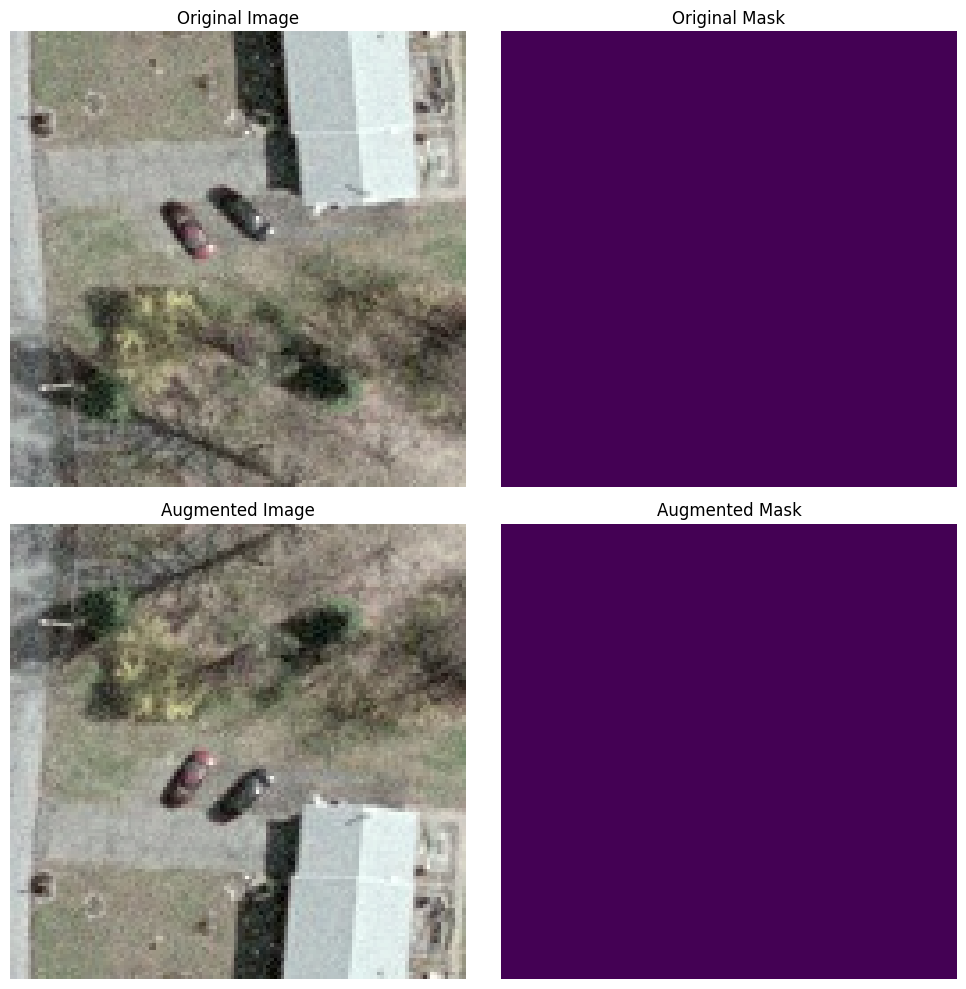

In [ ]:
# Plot a few examples
for i in range(1):
  idx = np.random.randint(0, len(image_dataset))
  plot_augmentation(
      image_dataset[idx],
      mask_dataset[idx],
      augmented_image_dataset[idx*2+1],
      augmented_mask_dataset[idx*2+1]
  )

#Continue checking original dataset

In [ ]:
mask_dataset[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
mask_dataset = np.expand_dims(mask_dataset, axis=3)

In [ ]:
mask_dataset[1400]

array([[[3],
        [3],
        [3],
        ...,
        [3],
        [3],
        [3]],

       [[3],
        [3],
        [3],
        ...,
        [3],
        [3],
        [3]],

       [[3],
        [3],
        [3],
        ...,
        [3],
        [3],
        [3]],

       ...,

       [[3],
        [3],
        [3],
        ...,
        [3],
        [3],
        [3]],

       [[3],
        [3],
        [3],
        ...,
        [3],
        [3],
        [3]],

       [[3],
        [3],
        [3],
        ...,
        [3],
        [3],
        [3]]])

In [16]:
print("Image dataset shape:", image_dataset.shape)
print("Mask dataset shape:", mask_dataset.shape)
print("Labels dataset shape:", labels_dataset.shape)

# Print unique values in mask_dataset to confirm correct labeling
print("Unique values in mask_dataset:", np.unique(mask_dataset))

Image dataset shape: (1594, 128, 128, 3)
Mask dataset shape: (1594, 128, 128, 1)
Labels dataset shape: (1594,)
Unique values in mask_dataset: [0 1 2 3]


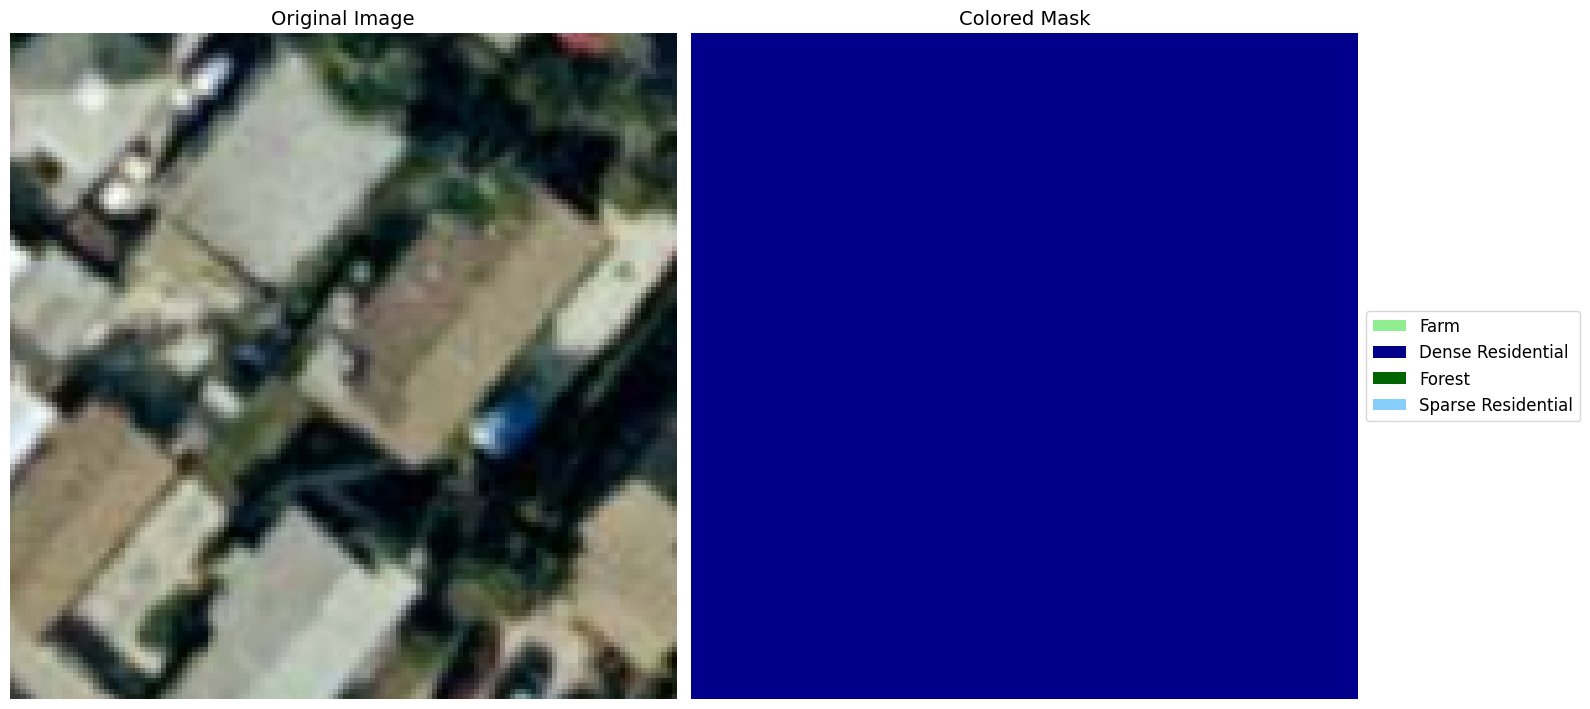

Category: Dense Residential


In [ ]:
# Select a random image and its corresponding mask
random_image_id = random.randint(0, len(image_dataset) - 1)
random_image = image_dataset[random_image_id]
random_mask = mask_dataset[random_image_id]

# Apply color mapping to the mask
colored_mask = apply_color_mapping(random_mask)
# Squeeze the colored mask to remove the extra dimension
colored_mask = np.squeeze(colored_mask)

# Create the plot
plt.figure(figsize=(16, 8))

# Display original image
plt.subplot(121)
plt.title("Original Image", fontsize=14)
plt.imshow(random_image)
plt.axis('off')

# Display colored mask
plt.subplot(122)
plt.title("Colored Mask", fontsize=14)
plt.imshow(colored_mask)
plt.axis('off')

# Create a custom legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color_mapping[label_mapping[cat.lower()]],
                               label=cat)
                 for cat in categories]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

# Print the category of the selected image
print(f"Category: {categories[label_mapping[labels_dataset[random_image_id]]]}")

#EDA

In [ ]:
from collections import Counter

Class distribution:
farm: 400
dense residential: 400
forest: 400
sparse residential: 394


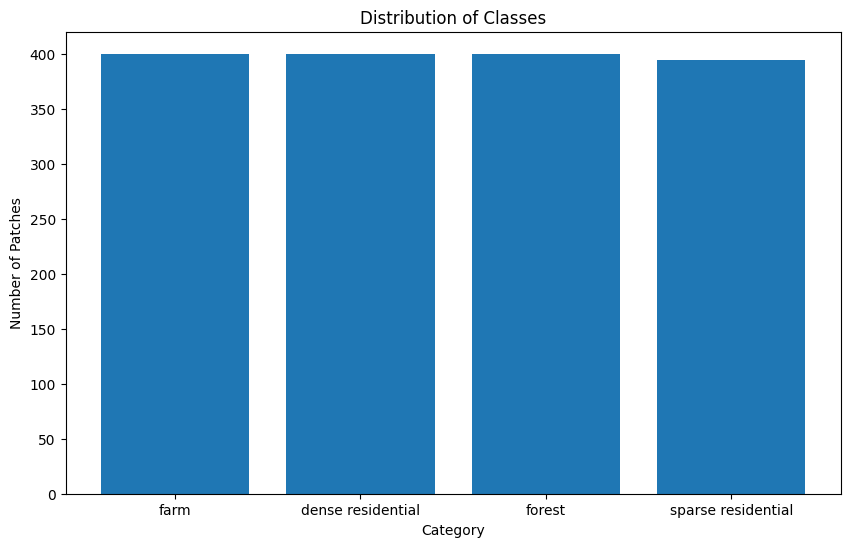

In [ ]:
#Count the occurrences of each class:
class_distribution = Counter(labels_dataset)

print("Class distribution:")
for category, count in class_distribution.items():
  print(f"{category}: {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Distribution of Classes")
plt.xlabel("Category")
plt.ylabel("Number of Patches")
plt.show()

In [ ]:
#Calculate the percentage of each class:
total_patches = len(labels_dataset)
for category, count in class_distribution.items():
  percentage = (count / total_patches) * 100
  print(f"{category}: {percentage:.2f}%")

farm: 25.09%
dense residential: 25.09%
forest: 25.09%
sparse residential: 24.72%


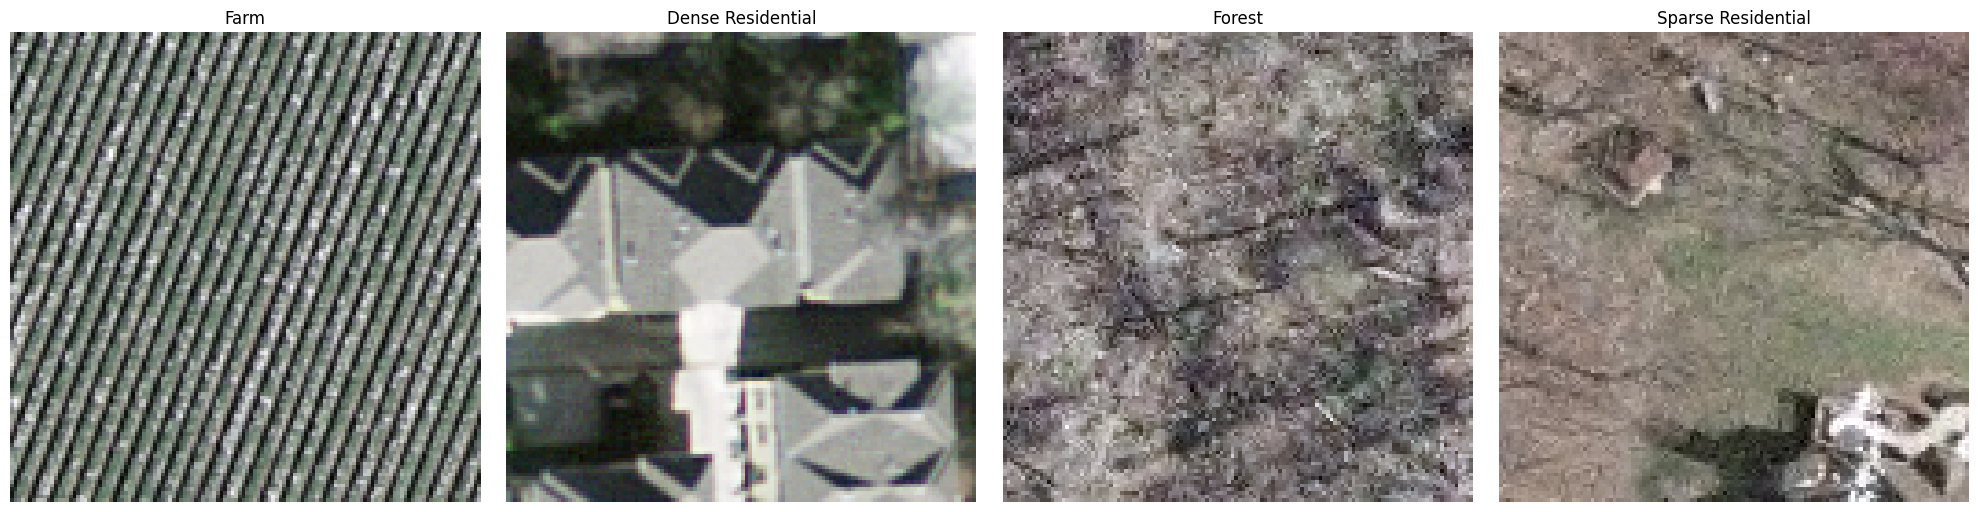

In [ ]:
#Display sample images from each category:
plt.figure(figsize=(20, 5))
for i, category in enumerate(categories):
  category_indices = np.where(labels_dataset == category.lower())[0]
  random_index = np.random.choice(category_indices)
  plt.subplot(1, 4, i+1)
  plt.imshow(image_dataset[random_index])
  plt.title(category)
  plt.axis('off')
plt.tight_layout()
plt.show()

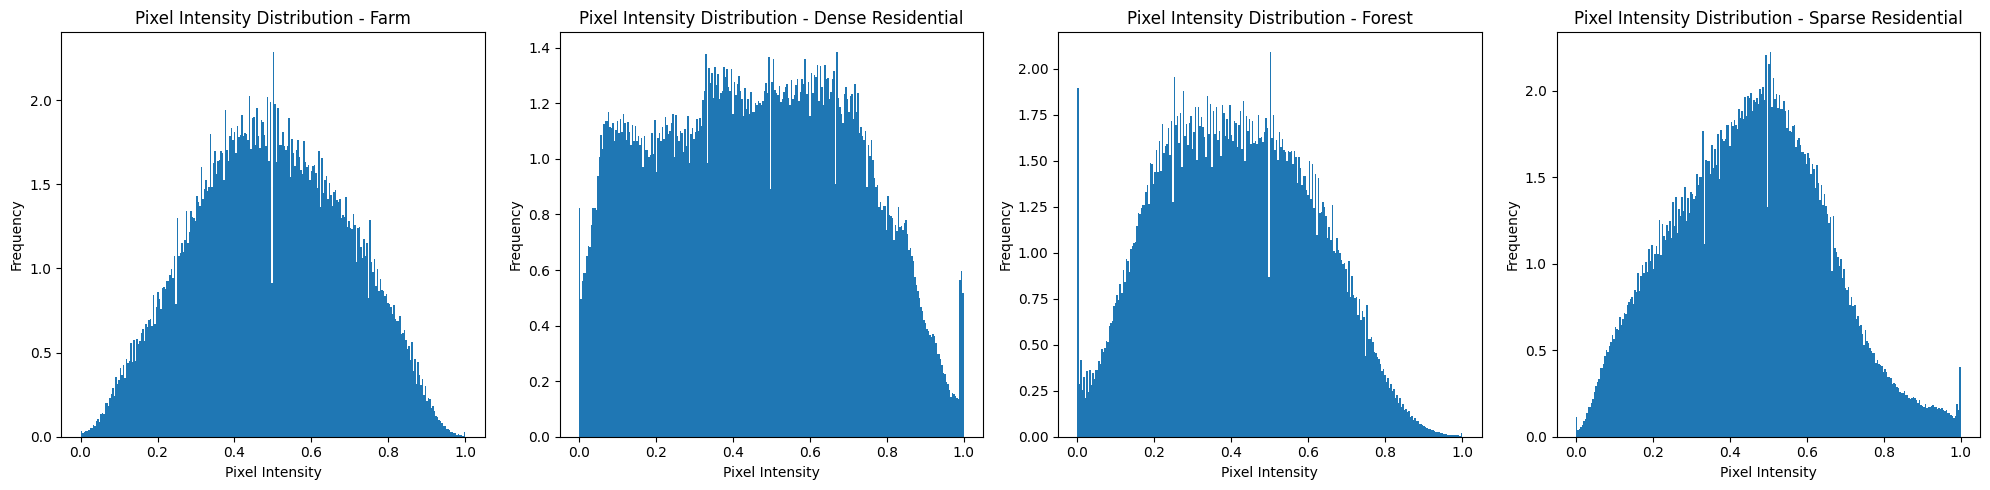

In [ ]:
#Analyze pixel intensity distribution for each category:
plt.figure(figsize=(20, 5))
for i, category in enumerate(categories):
  category_indices = np.where(labels_dataset == category.lower())[0]
  category_images = image_dataset[category_indices]
  plt.subplot(1, 4, i+1)
  plt.hist(category_images.ravel(), bins=256, range=(0, 1), density=True)
  plt.title(f"Pixel Intensity Distribution - {category}")
  plt.xlabel("Pixel Intensity")
  plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Training and testing Dataset

In [17]:
total_classes = len(np.unique(mask_dataset))
total_classes

4

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
mask_dataset[1000]

array([[[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       ...,

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]]])

In [19]:
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

In [ ]:
labels_categorical_dataset[1000]

array([[[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       ...,

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0.

In [ ]:
labels_categorical_dataset.shape

(1594, 128, 128, 4)

In [20]:
master_trianing_dataset = image_dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.30, random_state=100)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1115, 128, 128, 3)
(479, 128, 128, 3)
(1115, 128, 128, 4)
(479, 128, 128, 4)


In [23]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

128
128
3
4


# Deep Learning with Satellite Imagery Data

In [24]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [25]:
from keras import backend as K

In [11]:
#https://en.wikipedia.org/wiki/Jaccard_index
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [27]:
def multi_unet_model(n_classes=3, image_height=128, image_width=128, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1) #drop 20% value
  c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(8, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [28]:
metrics = ["accuracy", jaccard_coef]

In [29]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [30]:
model = get_deep_learning_model()

In [ ]:
model.get_config()

{'name': 'model_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_2'},
   'name': 'input_2',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_19',
    'trainable': True,
    'dtype': 'float32',
    'filters': 8,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d_19',
   'inbound_nodes': [[['input_2', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'n

#Generating Loss Function

*   dice loss > Focal Loss > Total Loss
*   Total Loss = (Dice loss + (1*Focal Loss))



In [8]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [9]:
weights = [0.25, 0.25, 0.25, 0.25] # 4 classes so equal weight 1/4

In [10]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [34]:
total_loss

#Model compilation

In [35]:
import tensorflow as tf

In [36]:
tf.keras.backend.clear_session()

In [37]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 8)  224         ['input_2[0][0]']                
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 8)  0           ['conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 8)  584         ['dropout_9[0][0]']        

#Visualize Model with Keras

In [38]:
from keras.utils.vis_utils import plot_model

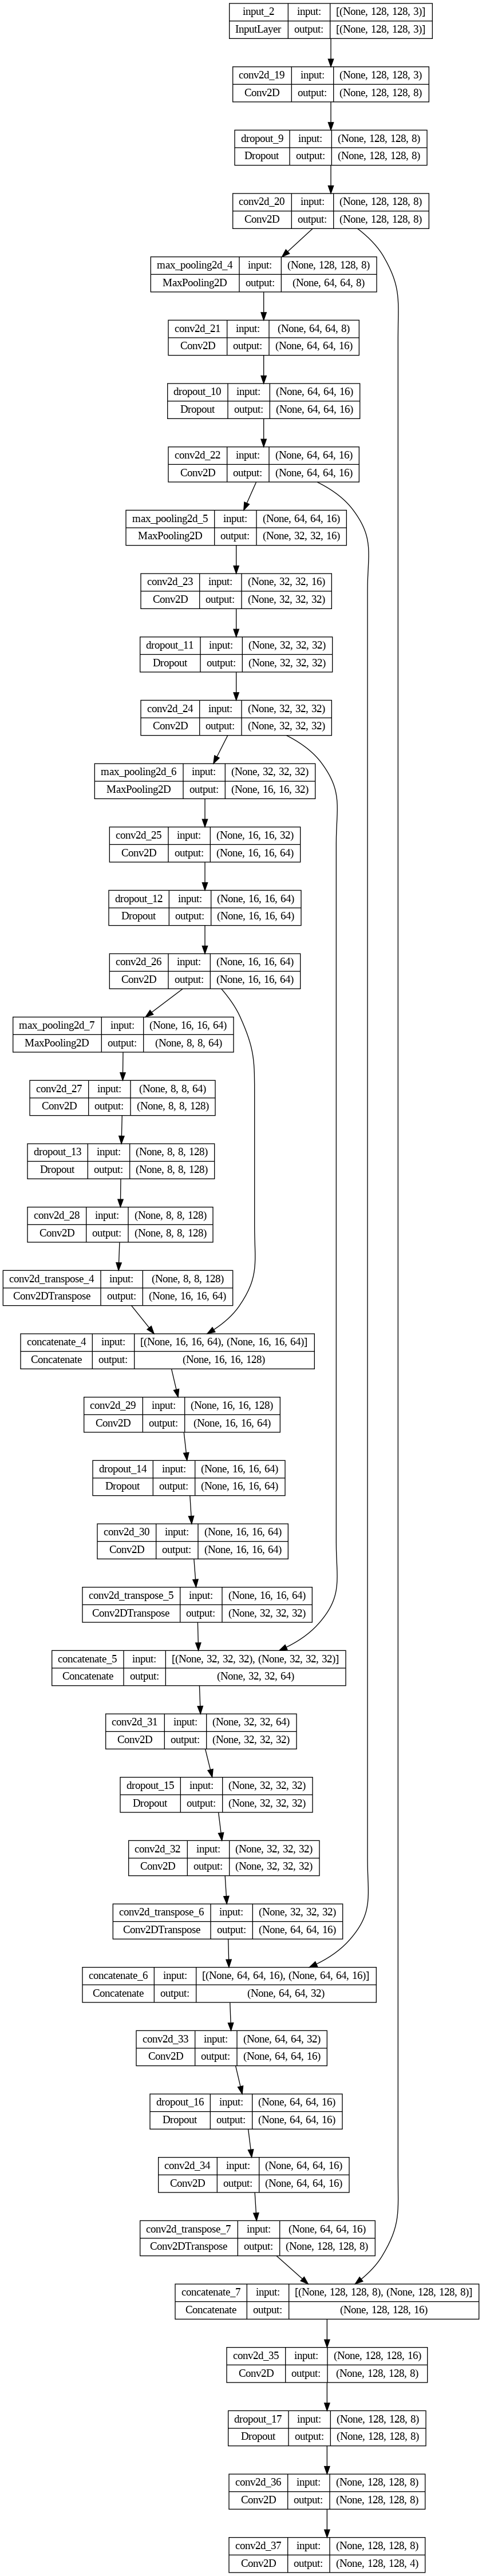

In [ ]:
plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)

In [39]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [40]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)

    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

In [41]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00


In [42]:
!pip install --upgrade wandb

In [43]:
# Log in to your W&B account
import wandb
# Use wandb-core, temporary for wandb's new backend
wandb.require("core")
#from wandb.keras import WandbCallback
from wandb.integration.keras import WandbCallback

In [44]:
wandb.init(project="satellite-imagery", entity="shivani-ds-university-of-south-australia")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [45]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [46]:
!wandb status

Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [47]:
wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})
wandb.config.dropout = 0.2

In [48]:
model_history = model.fit(X_train, y_train,
                          batch_size=16, #give based on total X_train dataset so 1115/16 = 70 times loop
                          verbose=1,
                          epochs=30, #going to run 10 times , once validate we will see with 50 or 70 or 100
                          validation_data=(X_test, y_test),
                          #callbacks=[plot_loss],
                          callbacks=[WandbCallback()], #for weight bias platform WandbEvalCallback
                          shuffle=False)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
70/70 [==============================] - ETA: 0s - loss: 0.9911 - accuracy: 0.2521 - jaccard_coef: 0.1433

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 126s 2s/step - loss: 0.9911 - accuracy: 0.2521 - jaccard_coef: 0.1433 - val_loss: 0.9897 - val_accuracy: 0.2695 - val_jaccard_coef: 0.1430
Epoch 2/30
70/70 [==============================] - ETA: 0s - loss: 0.9888 - accuracy: 0.2498 - jaccard_coef: 0.1437

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 108s 2s/step - loss: 0.9888 - accuracy: 0.2498 - jaccard_coef: 0.1437 - val_loss: 0.9894 - val_accuracy: 0.2427 - val_jaccard_coef: 0.1435
Epoch 3/30
70/70 [==============================] - ETA: 0s - loss: 0.9871 - accuracy: 0.2886 - jaccard_coef: 0.1479

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 107s 2s/step - loss: 0.9871 - accuracy: 0.2886 - jaccard_coef: 0.1479 - val_loss: 0.9889 - val_accuracy: 0.3019 - val_jaccard_coef: 0.1442
Epoch 4/30
70/70 [==============================] - ETA: 0s - loss: 0.9835 - accuracy: 0.3268 - jaccard_coef: 0.1561

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 107s 2s/step - loss: 0.9835 - accuracy: 0.3268 - jaccard_coef: 0.1561 - val_loss: 0.9806 - val_accuracy: 0.3894 - val_jaccard_coef: 0.1865
Epoch 5/30
70/70 [==============================] - ETA: 0s - loss: 0.9732 - accuracy: 0.3837 - jaccard_coef: 0.1816

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 104s 1s/step - loss: 0.9732 - accuracy: 0.3837 - jaccard_coef: 0.1816 - val_loss: 0.9744 - val_accuracy: 0.4764 - val_jaccard_coef: 0.1675
Epoch 6/30
70/70 [==============================] - ETA: 0s - loss: 0.9601 - accuracy: 0.4819 - jaccard_coef: 0.2151

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 103s 1s/step - loss: 0.9601 - accuracy: 0.4819 - jaccard_coef: 0.2151 - val_loss: 0.9511 - val_accuracy: 0.6017 - val_jaccard_coef: 0.2279
Epoch 7/30
70/70 [==============================] - ETA: 0s - loss: 0.9430 - accuracy: 0.5748 - jaccard_coef: 0.2518

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 107s 2s/step - loss: 0.9430 - accuracy: 0.5748 - jaccard_coef: 0.2518 - val_loss: 0.9462 - val_accuracy: 0.6051 - val_jaccard_coef: 0.2310
Epoch 8/30
70/70 [==============================] - ETA: 0s - loss: 0.9232 - accuracy: 0.6089 - jaccard_coef: 0.3111

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 105s 1s/step - loss: 0.9232 - accuracy: 0.6089 - jaccard_coef: 0.3111 - val_loss: 0.9144 - val_accuracy: 0.6445 - val_jaccard_coef: 0.3238
Epoch 9/30
70/70 [==============================] - ETA: 0s - loss: 0.9018 - accuracy: 0.6407 - jaccard_coef: 0.3820

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 103s 1s/step - loss: 0.9018 - accuracy: 0.6407 - jaccard_coef: 0.3820 - val_loss: 0.9017 - val_accuracy: 0.6674 - val_jaccard_coef: 0.3572
Epoch 10/30
70/70 [==============================] - ETA: 0s - loss: 0.8878 - accuracy: 0.6803 - jaccard_coef: 0.4292

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 106s 2s/step - loss: 0.8878 - accuracy: 0.6803 - jaccard_coef: 0.4292 - val_loss: 0.8947 - val_accuracy: 0.6805 - val_jaccard_coef: 0.4128
Epoch 11/30
70/70 [==============================] - ETA: 0s - loss: 0.8713 - accuracy: 0.7303 - jaccard_coef: 0.4874

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 106s 2s/step - loss: 0.8713 - accuracy: 0.7303 - jaccard_coef: 0.4874 - val_loss: 0.8650 - val_accuracy: 0.7589 - val_jaccard_coef: 0.5144
Epoch 12/30
70/70 [==============================] - ETA: 0s - loss: 0.8557 - accuracy: 0.7639 - jaccard_coef: 0.5472

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 108s 2s/step - loss: 0.8557 - accuracy: 0.7639 - jaccard_coef: 0.5472 - val_loss: 0.8646 - val_accuracy: 0.7627 - val_jaccard_coef: 0.5321
Epoch 13/30
70/70 [==============================] - ETA: 0s - loss: 0.8517 - accuracy: 0.7777 - jaccard_coef: 0.5664

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 106s 2s/step - loss: 0.8517 - accuracy: 0.7777 - jaccard_coef: 0.5664 - val_loss: 0.8630 - val_accuracy: 0.7596 - val_jaccard_coef: 0.5303
Epoch 14/30
70/70 [==============================] - ETA: 0s - loss: 0.8401 - accuracy: 0.8056 - jaccard_coef: 0.6055

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 105s 2s/step - loss: 0.8401 - accuracy: 0.8056 - jaccard_coef: 0.6055 - val_loss: 0.8602 - val_accuracy: 0.7726 - val_jaccard_coef: 0.5612
Epoch 15/30
70/70 [==============================] - ETA: 0s - loss: 0.8427 - accuracy: 0.7976 - jaccard_coef: 0.5990

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 106s 2s/step - loss: 0.8427 - accuracy: 0.7976 - jaccard_coef: 0.5990 - val_loss: 0.8583 - val_accuracy: 0.7827 - val_jaccard_coef: 0.5743
Epoch 16/30
70/70 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.8165 - jaccard_coef: 0.6232

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 108s 2s/step - loss: 0.8358 - accuracy: 0.8165 - jaccard_coef: 0.6232 - val_loss: 0.8455 - val_accuracy: 0.8087 - val_jaccard_coef: 0.6135
Epoch 17/30
70/70 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.8229 - jaccard_coef: 0.6328

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 108s 2s/step - loss: 0.8348 - accuracy: 0.8229 - jaccard_coef: 0.6328 - val_loss: 0.8389 - val_accuracy: 0.8205 - val_jaccard_coef: 0.6217
Epoch 18/30
70/70 [==============================] - 103s 1s/step - loss: 0.8286 - accuracy: 0.8374 - jaccard_coef: 0.6542 - val_loss: 0.8439 - val_accuracy: 0.8102 - val_jaccard_coef: 0.6185
Epoch 19/30
70/70 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.8384 - jaccard_coef: 0.6634

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 108s 2s/step - loss: 0.8272 - accuracy: 0.8384 - jaccard_coef: 0.6634 - val_loss: 0.8268 - val_accuracy: 0.8499 - val_jaccard_coef: 0.6753
Epoch 20/30
70/70 [==============================] - ETA: 0s - loss: 0.8225 - accuracy: 0.8492 - jaccard_coef: 0.6824

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 107s 2s/step - loss: 0.8225 - accuracy: 0.8492 - jaccard_coef: 0.6824 - val_loss: 0.8259 - val_accuracy: 0.8543 - val_jaccard_coef: 0.6660
Epoch 21/30
70/70 [==============================] - 103s 1s/step - loss: 0.8242 - accuracy: 0.8463 - jaccard_coef: 0.6745 - val_loss: 0.8403 - val_accuracy: 0.8145 - val_jaccard_coef: 0.6364
Epoch 22/30
70/70 [==============================] - ETA: 0s - loss: 0.8172 - accuracy: 0.8593 - jaccard_coef: 0.6984

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 106s 2s/step - loss: 0.8172 - accuracy: 0.8593 - jaccard_coef: 0.6984 - val_loss: 0.8196 - val_accuracy: 0.8683 - val_jaccard_coef: 0.7114
Epoch 23/30
70/70 [==============================] - 105s 1s/step - loss: 0.8146 - accuracy: 0.8674 - jaccard_coef: 0.7180 - val_loss: 0.8314 - val_accuracy: 0.8332 - val_jaccard_coef: 0.6650
Epoch 24/30
70/70 [==============================] - ETA: 0s - loss: 0.8187 - accuracy: 0.8573 - jaccard_coef: 0.6976

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 103s 1s/step - loss: 0.8187 - accuracy: 0.8573 - jaccard_coef: 0.6976 - val_loss: 0.8165 - val_accuracy: 0.8751 - val_jaccard_coef: 0.7139
Epoch 25/30
70/70 [==============================] - ETA: 0s - loss: 0.8137 - accuracy: 0.8699 - jaccard_coef: 0.7189

wandb: Adding directory to artifact (/content/wandb/run-20240901_071429-f9rlo1y6/files/model-best)... Done. 0.0s


70/70 [==============================] - 101s 1s/step - loss: 0.8137 - accuracy: 0.8699 - jaccard_coef: 0.7189 - val_loss: 0.8096 - val_accuracy: 0.8884 - val_jaccard_coef: 0.7520
Epoch 26/30
70/70 [==============================] - 97s 1s/step - loss: 0.8059 - accuracy: 0.8883 - jaccard_coef: 0.7527 - val_loss: 0.8280 - val_accuracy: 0.8496 - val_jaccard_coef: 0.7005
Epoch 27/30
70/70 [==============================] - 97s 1s/step - loss: 0.8042 - accuracy: 0.8917 - jaccard_coef: 0.7622 - val_loss: 0.8144 - val_accuracy: 0.8752 - val_jaccard_coef: 0.7380
Epoch 28/30
70/70 [==============================] - 98s 1s/step - loss: 0.8035 - accuracy: 0.8905 - jaccard_coef: 0.7619 - val_loss: 0.8243 - val_accuracy: 0.8501 - val_jaccard_coef: 0.6989
Epoch 29/30
70/70 [==============================] - 99s 1s/step - loss: 0.8057 - accuracy: 0.8867 - jaccard_coef: 0.7532 - val_loss: 0.8291 - val_accuracy: 0.8416 - val_jaccard_coef: 0.6989
Epoch 30/30
70/70 [==============================] - 100

In [49]:
history_a = model_history
history_a.history

{'loss': [0.9911321401596069,
  0.9887664914131165,
  0.9871246814727783,
  0.9834842681884766,
  0.973210334777832,
  0.960120439529419,
  0.9429786205291748,
  0.9232131838798523,
  0.901789128780365,
  0.8877605199813843,
  0.8713212609291077,
  0.8557220697402954,
  0.8516944646835327,
  0.8400972485542297,
  0.8427429795265198,
  0.8357670903205872,
  0.834825336933136,
  0.8285530209541321,
  0.8271875977516174,
  0.8225497007369995,
  0.8242010474205017,
  0.817199170589447,
  0.8146191239356995,
  0.8187295198440552,
  0.8137070536613464,
  0.8058801889419556,
  0.8042438626289368,
  0.8034626841545105,
  0.8056718707084656,
  0.8022011518478394],
 'accuracy': [0.2521476149559021,
  0.24984130263328552,
  0.2885981500148773,
  0.3267962336540222,
  0.3836812674999237,
  0.48185160756111145,
  0.5747529864311218,
  0.6089218854904175,
  0.6407402753829956,
  0.6802535057067871,
  0.7302504777908325,
  0.7639042139053345,
  0.777678370475769,
  0.8055867552757263,
  0.79756462574

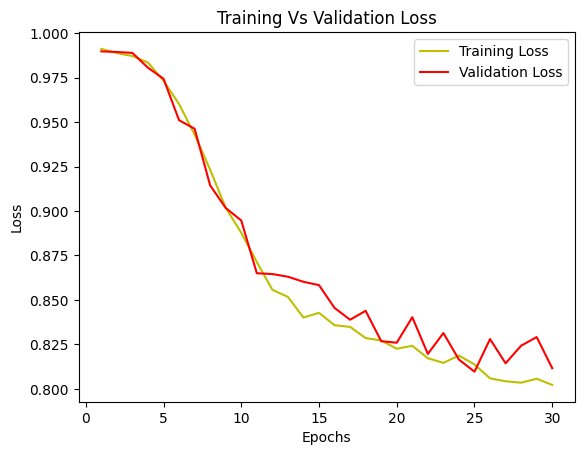

In [50]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#sepration of validation and training is not bigger and bigger

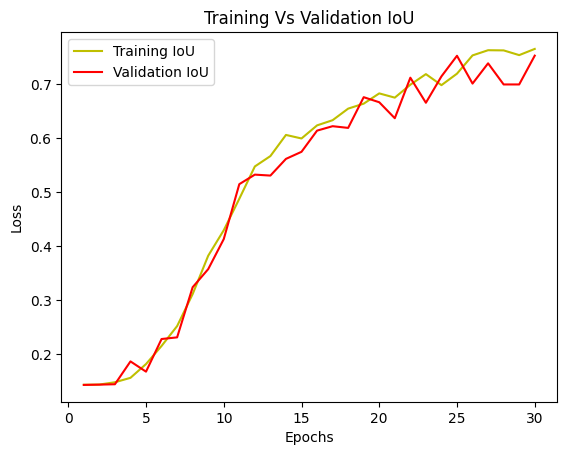

In [51]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#we need to check this validation IoU, it should be more
#we can reduce dropout while making model

In [52]:
model_history.params

{'verbose': 1, 'epochs': 30, 'steps': 70}

In [53]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1115, 128, 128, 3)
(479, 128, 128, 3)
(1115, 128, 128, 4)
(479, 128, 128, 4)


In [54]:
y_pred = model.predict(X_test)
print(len(y_pred))
print(y_pred)

15/15 [==============================] - 8s 464ms/step
479
[[[[6.64991915e-01 4.44108248e-03 1.18008010e-01 2.12559074e-01]
   [8.08396041e-01 4.84812830e-04 8.25696662e-02 1.08549573e-01]
   [9.09900844e-01 8.10805868e-05 3.71557288e-02 5.28623126e-02]
   ...
   [8.62030506e-01 1.73822016e-04 5.94589934e-02 7.83366114e-02]
   [7.87154198e-01 5.59395179e-04 1.00815654e-01 1.11470841e-01]
   [7.19464660e-01 5.06950356e-03 1.14315771e-01 1.61150098e-01]]

  [[8.58791173e-01 4.58986731e-04 4.24131304e-02 9.83367413e-02]
   [9.62062418e-01 8.34173625e-06 1.33236442e-02 2.46055946e-02]
   [9.82847810e-01 1.21154437e-06 6.61677076e-03 1.05342958e-02]
   ...
   [9.80383098e-01 2.29703210e-06 4.94746678e-03 1.46670267e-02]
   [9.50182557e-01 2.27442815e-05 1.64214708e-02 3.33730951e-02]
   [8.57442319e-01 1.10070733e-03 3.08423880e-02 1.10614628e-01]]

  [[9.31003273e-01 8.12026119e-05 1.88260898e-02 5.00894114e-02]
   [9.82397914e-01 7.81871506e-07 6.73797308e-03 1.08633684e-02]
   [9.9463367

In [55]:
y_pred_argmax = np.argmax(y_pred, axis=3)
print(len(y_pred_argmax))
print(y_pred_argmax)

479
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  ...
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]]

 [[3 3 3 ... 3 3 2]
  [3 3 3 ... 3 3 3]
  [3 3 3 ... 3 3 3]
  ...
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]]

 ...

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [3 1 1 ... 1 1 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[3 3 3 ... 3 3 3]
  [3 3 3 ... 1 1 1]
  [3 3 3 ... 1 1 1]
  ...
  [3 3 3 ... 3 3 3]
  [3 3 3 ... 3 3 3]
  [3 3 3 ... 3 3 3]]]


In [56]:
y_test_argmax = np.argmax(y_test, axis=3)
y_test_argmax

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]],

       [[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

#Comparing prediction results


*   using test images using images and predicted result images



In [69]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 35ms/step


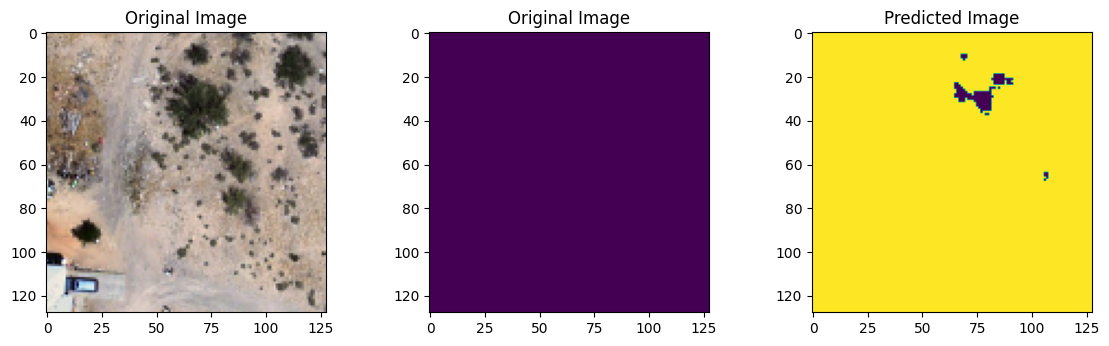

In [70]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

#Model save and reload

In [5]:
from keras.models import load_model

In [72]:
model.save("satellite_segmentation_full.h5")

In [13]:
saved_model = load_model('/content/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [ ]:
#saved_model.get_config()

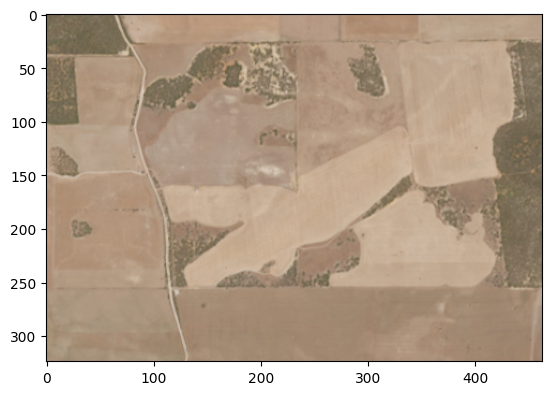

In [30]:
img = os.path.join(base_input_folder, "image-1.tiff")
plt.imshow(Image.open(img))

In [31]:
original_image = Image.open(img)
def create_patches(image, patch_size=128):
  width, height = image.size
  patches = []
  for i in range(0, height, patch_size):
      for j in range(0, width, patch_size):
          patch = image.crop((j, i, j+patch_size, i+patch_size))
          patch_array = np.array(patch)
          patches.append(patch_array)
  return np.array(patches)

# Create patches
patches = create_patches(original_image)

In [32]:
patches.shape

(12, 128, 128, 3)

In [33]:
prediction = saved_model.predict(patches)
#predicted_image = np.argmax(prediction, axis=3)
#predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 186ms/step


In [34]:
prediction

array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 1.8594281e-09, 9.9999994e-01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 3.5526260e-33, 9.9999994e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.000

In [36]:
# Get the class with highest probability for each pixel
predicted_classes = np.argmax(prediction, axis=3)

# Reconstruct the full image from patches
def reconstruct_from_patches(patches, original_size):
  height, width = original_size
  reconstructed = np.zeros((height, width), dtype=np.uint8)
  patch_size = patches.shape[1]
  index = 0
  for i in range(0, height - patch_size + 1, patch_size): # Adjust loop range to avoid going out of bounds
      for j in range(0, width - patch_size + 1, patch_size):
          reconstructed[i:i+patch_size, j:j+patch_size] = patches[index]
          index += 1
  return reconstructed

predicted_image = reconstruct_from_patches(predicted_classes, original_image.size)

In [39]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [28]:
# Create a custom colormap
colors = [color_mapping[i] for i in range(4)]  # Assuming 4 classes (0 to 3)
custom_cmap = mcolors.ListedColormap(colors)

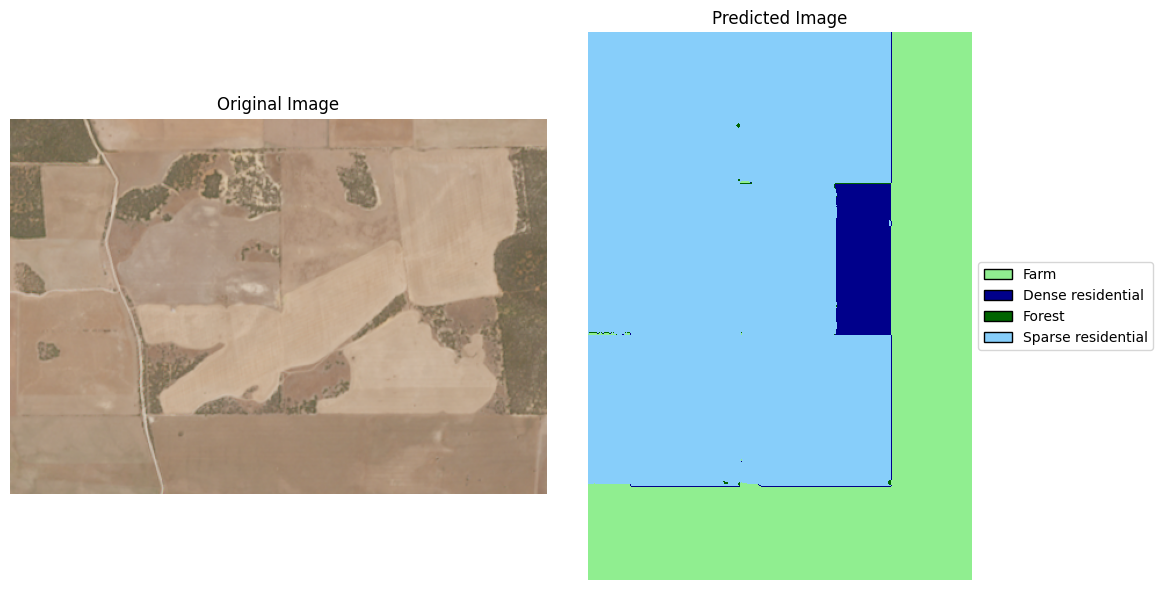

In [40]:
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(121)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

# Predicted Image
plt.subplot(122)
plt.title("Predicted Image")
plt.imshow(predicted_image, cmap=custom_cmap, vmin=0, vmax=3)  # You might want to use a different colormap
plt.axis('off')

# Create custom legend
legend_elements = [mpatches.Patch(facecolor=color_mapping[i], edgecolor='black',
                                label=list(label_mapping.keys())[i].capitalize())
                 for i in range(4)]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [41]:
print(f"Original image size: {original_image.size}")
print(f"Original image size: {predicted_image.size}")



Original image size: (463, 324)
Original image size: 150012
